<a href="https://colab.research.google.com/github/anya-chauhan/bytemasters/blob/main/recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np
import nltk
import re                                  # library for regular expression operations
import string                              # for string operations
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer


# Download NLTK resources
nltk.download('stopwords')

# Load the data
df = pd.read_csv('medium.csv')

# Remove duplicates
df = df.drop_duplicates()

# Fill missing values with empty strings
df['Title'].fillna('', inplace=True)
df['Subtitle'].fillna('', inplace=True)
df['Summary'].fillna('', inplace=True)

# Preprocess the text data
def process(text):
    """
    Process the text by tokenizing, removing stopwords and punctuation, and stemming.
    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text)
    clean_tokens = [stemmer.stem(word) for word in tokens if word not in stopwords_english and word not in string.punctuation]
    return clean_tokens

# Process and concatenate the 'Title', 'Subtitle', and 'Summary' columns
from collections import Counter

df_p = []

word_counts = Counter()

for i in range(len(df)):
    element = df.loc[i]
    title = process(element['Title'])
    subtitle = process(element['Subtitle'])
    summary = process(element['Summary'])
    concatenated_text = title + subtitle + summary
    word_counts.update(concatenated_text)
    df_p.append({"id": i, "processed_text": concatenated_text})

# Remove words that appear in more than 5% of the articles
common_words = {word for word, count in word_counts.items() if count / len(df) > 0.05}
for i, row in enumerate(df_p):
    df_p[i]['processed_text'] = [word for word in row['processed_text'] if word not in common_words or word in ["chatgpt", "copilot", "codewhisperer"]]

dfp = pd.DataFrame(df_p)

# Train a Word2Vec model
w2v_model = Word2Vec(dfp['processed_text'], min_count=1, vector_size=100, workers=4)

# Vectorize each article summary
def vectorize_sentence(sentence, model):
    """
    Vectorize the sentence using the Word2Vec model.
    """
    vec = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vec, axis=0) if vec else np.zeros(model.vector_size)

dfp['vec'] = dfp['processed_text'].apply(lambda x: vectorize_sentence(x, w2v_model))

# Calculate the cosine similarity matrix
similarity_matrix = cosine_similarity(np.vstack(dfp['vec'].values))

# Recommendation function
def get_recommendations(id, cosine_sim=similarity_matrix):
    """
    Get the 10 most similar articles to the given article ID based on cosine similarity.
    """
    idx = dfp.index[dfp['id'] == id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    article_indices = [i[0] for i in sim_scores]
    return dfp['id'].iloc[article_indices].tolist()[:5]

def display_article_info(article_id, df, dfp):
    article = df.loc[article_id]
    processed_article = dfp.loc[dfp['id'] == article_id]

    original_concatenated_text = f"{article['Title']} {article['Subtitle']} {article['Summary']}"
    processed_concatenated_text = ' '.join(processed_article['processed_text'].values[0])

    print(f"Original Concatenated Text: {original_concatenated_text}")
    print(f"Processed Concatenated Text: {processed_concatenated_text}\n")


def display_recommendations(article_id, df, dfp, recommendations):
    print(f"Recommendations for article {article_id}:")
    for rec_id in recommendations:
        display_article_info(rec_id, df, dfp)

# Test the recommendation function
recommendations = get_recommendations(487)
print("Article 487:")
display_article_info(487, df, dfp)
display_recommendations(487, df, dfp, recommendations)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Article 487:
Original Concatenated Text: ChatGPT for Developers: How to Comment and Refactor Your Code and Generate README Files  Welcome to my article on how to use ChatGPT to comment and refactor your code, as well as how to generate README files. As a developer, I understand the importance of well-written and organized code, as well as the need for clear and informative documentation. That’s why I’m excited to share with you how ChatGPT can assist in these tasks, making your workflow more efficient and effective.
Processed Concatenated Text: chatgpt comment refactor readm file welcom chatgpt comment refactor well readm file import well-written organ well clear inform document excit share chatgpt workflow effect

Recommendations for article 487:
Original Concatenated Text: How well can ChatGPT Create Code?  There’s been a lot of buzz around ChatGPT since its initial release. In an earlier article, I tested how well ChatGPT could re-create one of my articles. Surprisingly, it did a de

In [63]:
# 1. Vector Magnitude
df['vector_magnitude'] = dfp['vec'].apply(lambda x: np.linalg.norm(x))

# 2. Average Similarity Score
df['avg_similarity'] = similarity_matrix.mean(axis=1)

# 3. Number of Highly Similar Articles
threshold = 0.9  # Adjust this threshold as needed
df['num_highly_similar'] = (similarity_matrix > threshold).sum(axis=1) - 1

# Map the recommendations to the original DataFrame
df['rec_1'], df['rec_2'], df['rec_3'], df['rec_4'], df['rec_5'] = zip(*df.index.map(lambda x: get_recommendations(x, cosine_sim=similarity_matrix)))




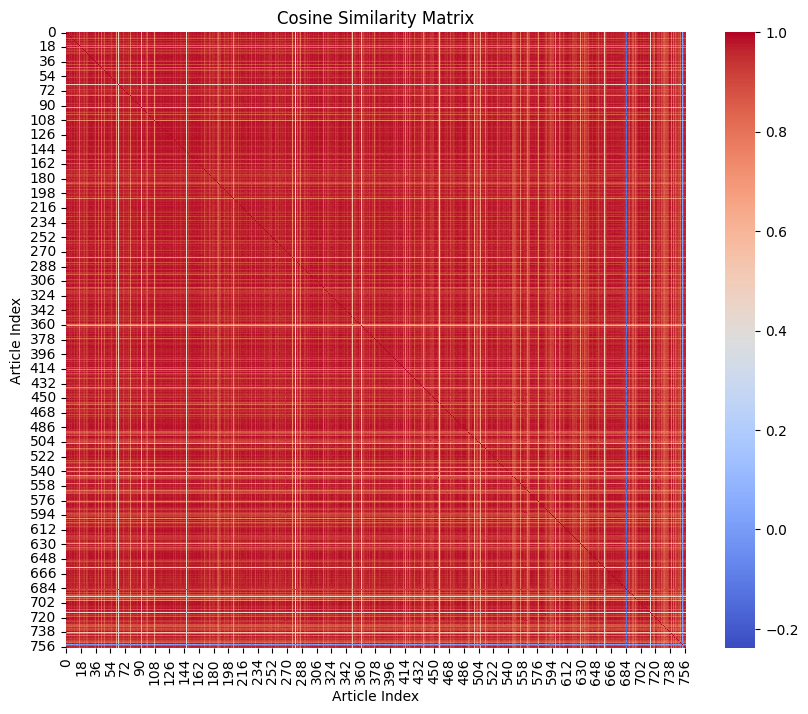

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the similarity matrix as a heatmap, check to see if model effective
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Article Index')
plt.ylabel('Article Index')
plt.show()

In [65]:
# !pip install transformers
from transformers import BertTokenizer, BertModel
import torch
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Encode the processed texts using BERT
def encode_sentence(sentence, tokenizer, model, max_length=128):
    """
    Encode the sentence using BERT.
    """
    inputs = tokenizer(sentence, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs['pooler_output'].numpy()

dfp['vec_BERT'] = dfp['processed_text'].apply(lambda x: encode_sentence(" ".join(x), tokenizer, model))

# Calculate the cosine similarity matrix using BERT embeddings
similarity_matrix_BERT = cosine_similarity(np.vstack(dfp['vec_BERT'].values))


In [66]:
def display_article_info(article_id, df, dfp):
    article = df.loc[article_id]
    processed_article = dfp.loc[dfp['id'] == article_id]

    original_concatenated_text = f"{article['Title']} {article['Subtitle']} {article['Summary']}"
    processed_concatenated_text = ' '.join(processed_article['processed_text'].values[0])

    print(f"Original Concatenated Text: {original_concatenated_text}")
    print(f"Processed Concatenated Text: {processed_concatenated_text}\n")


def display_recommendations(article_id, df, dfp, recommendations_BERT):
    print(f"Recommendations for article {article_id}:")
    for rec_id in recommendations_BERT:
        display_article_info(rec_id, df, dfp)

# Test the recommendation function
recommendations_BERT = get_recommendations(487, cosine_sim=similarity_matrix_BERT)
print("Article 487:")
display_article_info(487, df, dfp)
display_recommendations(487, df, dfp, recommendations_BERT)

Article 487:
Original Concatenated Text: ChatGPT for Developers: How to Comment and Refactor Your Code and Generate README Files  Welcome to my article on how to use ChatGPT to comment and refactor your code, as well as how to generate README files. As a developer, I understand the importance of well-written and organized code, as well as the need for clear and informative documentation. That’s why I’m excited to share with you how ChatGPT can assist in these tasks, making your workflow more efficient and effective.
Processed Concatenated Text: chatgpt comment refactor readm file welcom chatgpt comment refactor well readm file import well-written organ well clear inform document excit share chatgpt workflow effect

Recommendations for article 487:
Original Concatenated Text: ChatGPT and Markdown formats — Generating all Sorts of Editable Diagrams and Formats  This is a rapidly pulled-together blog post, mainly to share the results of getting ChatGPT to output Markdown. Markdown can be 

In [67]:


# Check the data types of the columns in dfp
print("\nData types of columns in dfp:")
print(dfp.dtypes)

# 1. Vector Magnitude
df['vector_magnitude_BERT'] = dfp['vec_BERT'].apply(lambda x: np.linalg.norm(x))

# 2. Average Similarity Score
df['avg_similarity_BERT'] = similarity_matrix_BERT.mean(axis=1)

# 3. Number of Highly Similar Articles
threshold = 0.9  # Adjust this threshold as needed
df['num_highly_similar_BERT'] = (similarity_matrix_BERT > threshold).sum(axis=1) - 1

# Map the recommendations to the original DataFrame
df['rec_1_BERT'], df['rec_2_BERT'], df['rec_3_BERT'], df['rec_4_BERT'], df['rec_5_BERT'] = zip(*df['ID'].index.map(lambda x: get_recommendations(x, cosine_sim=similarity_matrix_BERT)))




Data types of columns in dfp:
id                 int64
processed_text    object
vec               object
vec_BERT          object
dtype: object


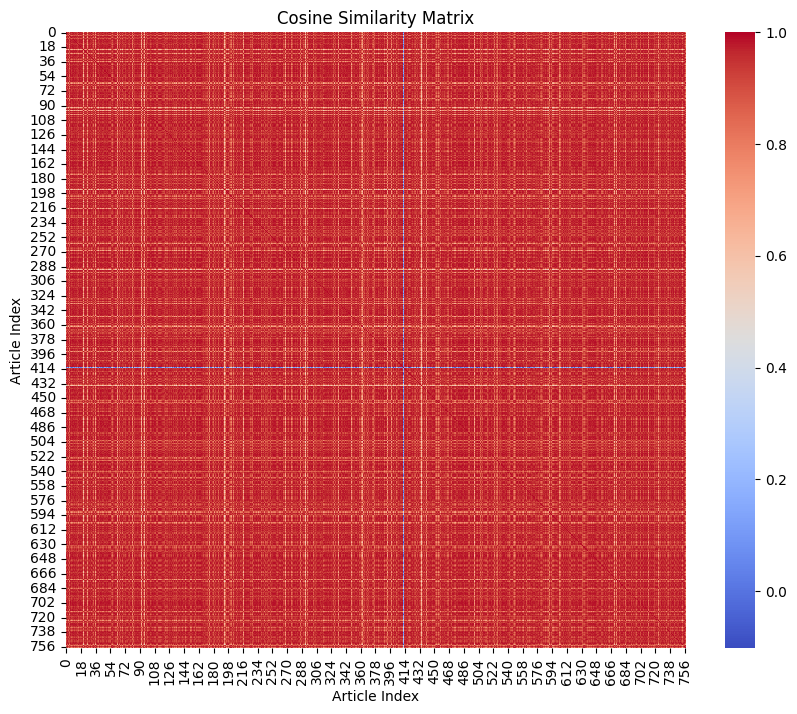

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_BERT, cmap='coolwarm')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Article Index')
plt.ylabel('Article Index')
plt.show()

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# Writing the updated DataFrame to a new CSV file
df.to_csv('/content/drive/My Drive/medium_updated_5%removal.csv', index=False)